# _Relax Inc Take-Home Challenge: Trial 1_

The data has the following two tables:

1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

- __name__:  the  user's  name
- __object_id__:   the  user's  id
- __email__:  email  address
- __creation_source__:   how  their  account  was  created.  This  takes  on  one
of  5  values:
    - __PERSONAL_PROJECTS__:  invited  to  join  another  user's personal  workspace
    - __GUEST_INVITE__:  invited  to  an  organization  as  a  guest (limited  permissions)
    - __ORG_INVITE__:  invited  to  an  organization  (as  a  full  member)
    - __SIGNUP__:  signed  up  via  the  website
    - __SIGNUP_GOOGLE_AUTH__:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
- __creation_time__:  when  they  created  their  account
- __last_session_creation_time__:   unix  timestamp  of  last  login
- __opted_in_to_mailing_list__:  whether  they  have  opted  into  receiving marketing  emails
- __enabled_for_marketing_drip__:  whether  they  are  on  the  regular marketing  email  drip
- __org_id__:   the  organization  (group  of  users)  they  belong  to
- __invited_by_user_id__:   which  user  invited  them  to  join  (if  applicable).

2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption .

In [226]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [227]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [228]:
path = os.getcwd()
path

'/Users/jai/Documents/Springboard-DS-Portfolio/unit17-take-home-challenges/relax_inc'

# _Load in Data_

In [229]:
users = pd.read_csv(path + '/data/takehome_users.csv', encoding='latin1')
engagement = pd.read_csv(path + '/data/takehome_user_engagement.csv')

In [230]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [231]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [232]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [233]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# _Difference between Sign-Ups and Usage_

In [234]:
from relax_challenge import relax

In [235]:
relax.unique_users(engagement, users)

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
That is a difference of 3177 users between those who have signed up for the app and those who have used it.


In [236]:
relax.last_sess_creation_time(users)

There are 3177 users who have never used the application.


As we can see above, there is a pretty significant difference between the number of people who have signed up for the application and those who have actually used it. In numerical terms, just over 26% of individuals who signed up for the app did not use it. 

These two data sets are giving us different information, so let's first clarify how we might best put them to use. Our `engagement` data set essentially gives us a summary of usage with a row for each day a user logged in. We can use this data to determine whether or not a user has adopted the app (i.e. they logged in on three separate days in a one week period). 

After we determine who the adopted users are, we can then use the second data set - `users` - to try and create a classification model that is able to predict based on a set of features who ends up using the app and who does not. 

# _Determining Adopted Users_

In [237]:
# the most simple thing to start with is convert the time_stamp column in engagement to a datetime object
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [238]:
# set time_stamp as index
engagement.set_index('time_stamp', drop=True, inplace=True)

In [239]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [240]:
from relax_challenge import relax

engagement_df, users_df = relax.apply_adopt(engagement, users);

Created adopted_user column and applied adopted_user function.
------------------------------
There are 1656 adopted users or 13.8% of total users.


# _Data Wrangling/Clean-up_

In [241]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [242]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [243]:
clean_users_df = relax.users_cleanup(users_df);

Converted creation_time columns to datetime.
------------------------------
Created column that extracts email provider; if not in top five, case receives other label.
------------------------------
Converted ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted_user'] columns to categorical type.
------------------------------
Filled in missing values.
------------------------------
Created dummy columns (i.e. one-hot encoded) for creation source and email provider columns.


In [244]:
clean_users_df.head(10)

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_provider_cuvox.de,email_provider_gmail.com,email_provider_gustr.com,email_provider_hotmail.com,email_provider_jourrapide.com,email_provider_other,email_provider_yahoo.com
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,1.387424e+09,0,0,197,11241.0,0,1,0,0,0,0,0,0,0,0,0,0,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,1.356010e+09,0,1,37,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,0.000000e+00,1,1,74,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,0.000000e+00,0,0,302,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,1.401833e+09,1,1,318,4143.0,1,0,1,0,0,0,0,0,1,0,0,0,0


In [245]:
clean_users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 22 columns):
object_id                             12000 non-null int64
creation_time                         12000 non-null datetime64[ns]
name                                  12000 non-null object
email                                 12000 non-null object
last_session_creation_time            12000 non-null float64
opted_in_to_mailing_list              12000 non-null category
enabled_for_marketing_drip            12000 non-null category
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
adopted_user                          12000 non-null category
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    120

# _Machine Learning_

In [246]:
X = clean_users_df.drop(['object_id', 'creation_time', 'name', 'email', 'adopted_user'], axis=1)
y = clean_users_df['adopted_user']

Mean ROC-AUC score of test set for Baseline Random Forest: 0.892
Mean Precision score of test set for Baseline Random Forest: 0.742
Mean Recall score of test set for Baseline Random Forest: 0.590


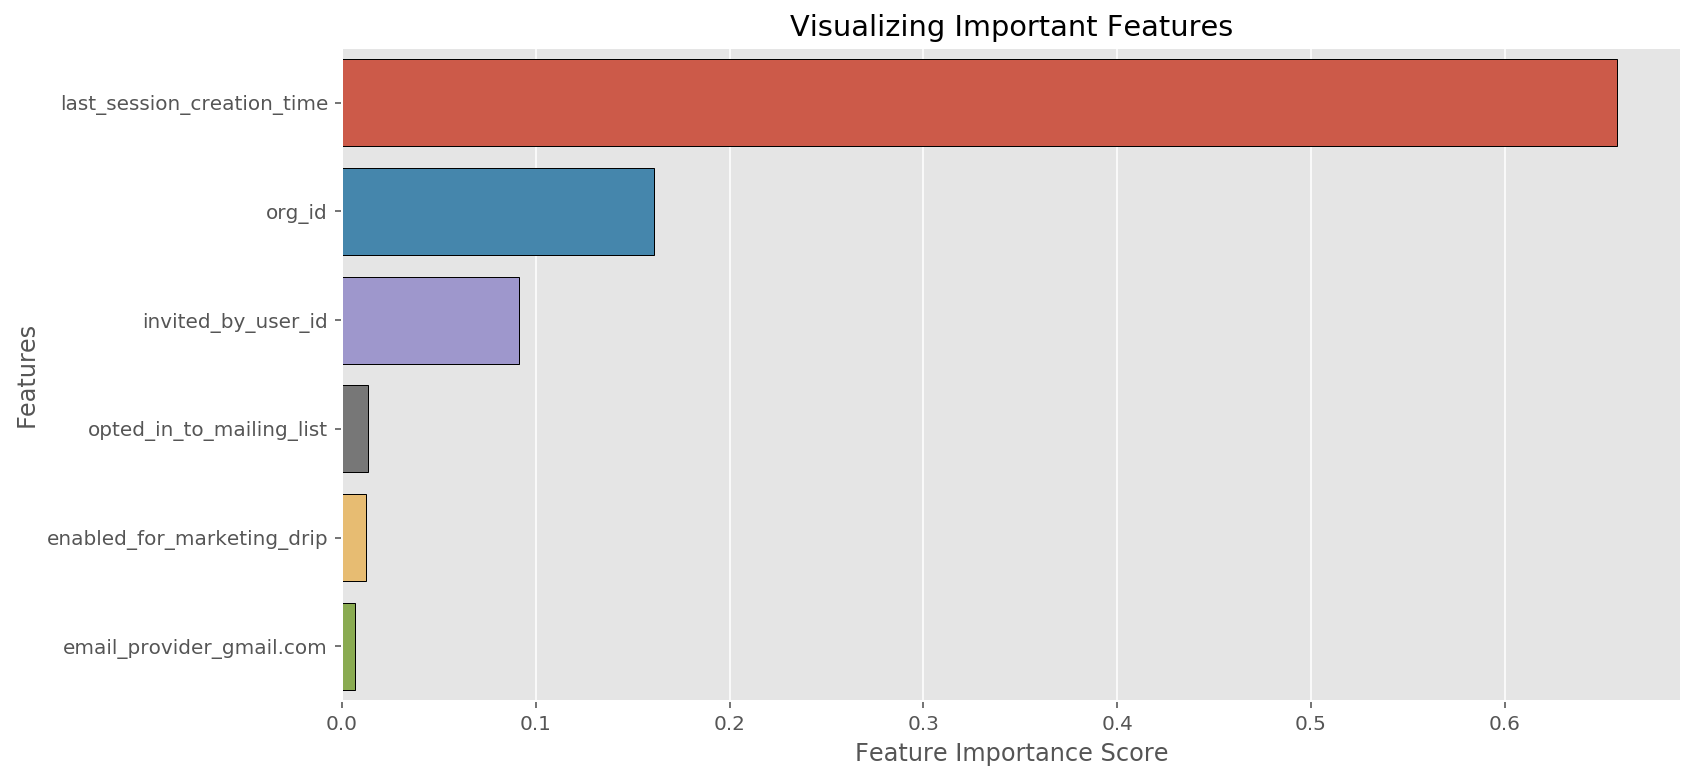

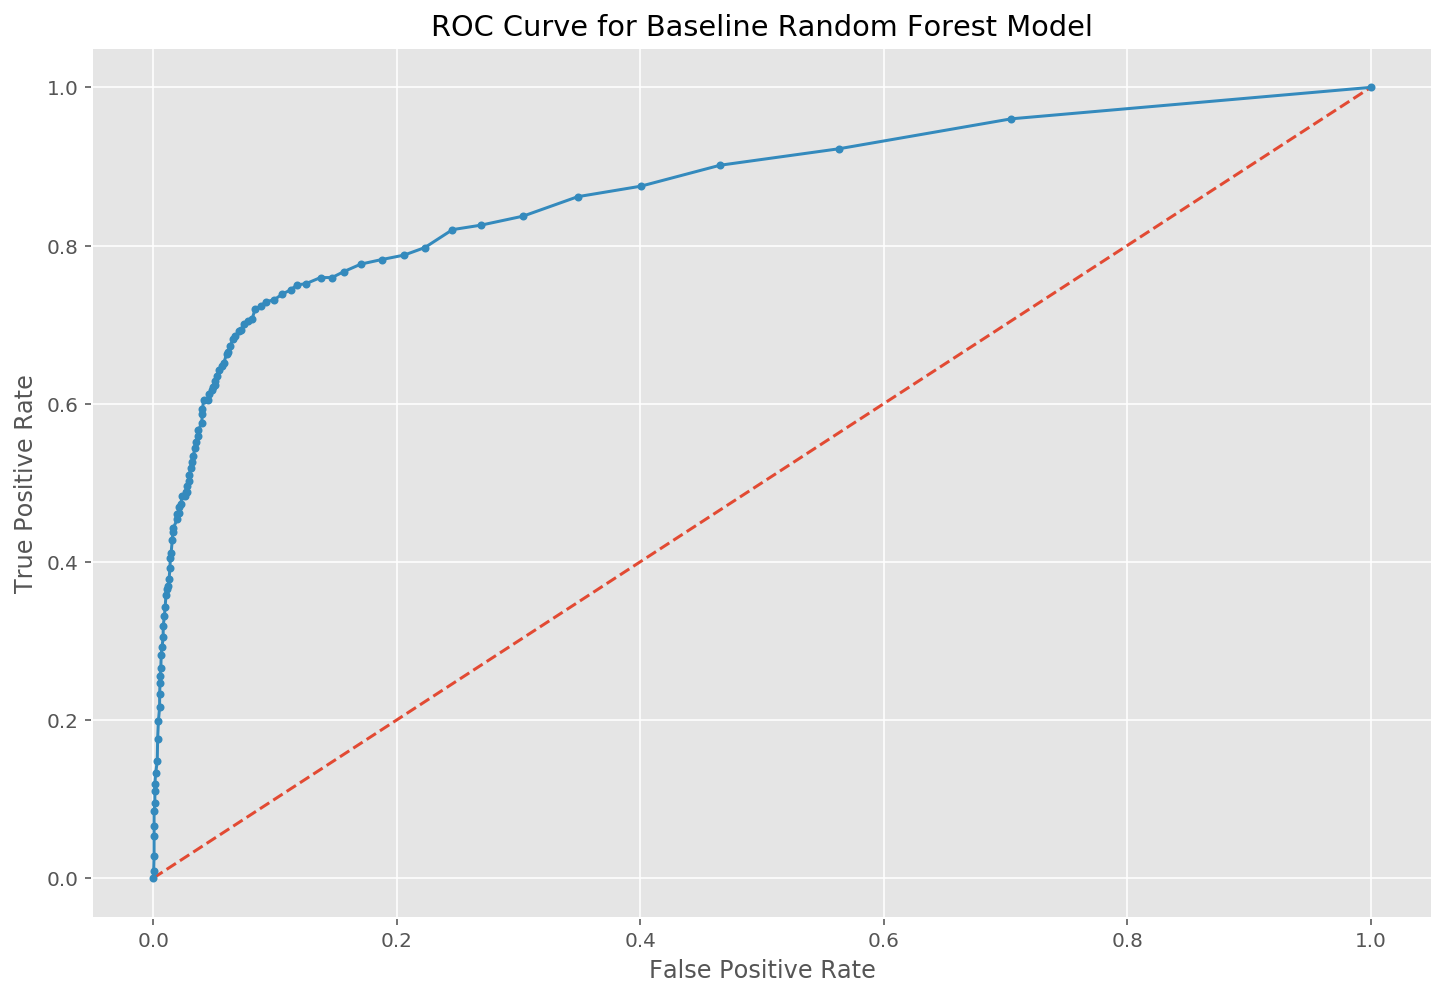

In [247]:
relax.ml_baseline(X, y, random_state=1, title='Baseline Random Forest');

# _Observations_

Not a bad baseline! It looks like this model does a fairly decent job in detecting adopted users. However, if you remember from earlier, there was a pretty significant class imbalance with only ~14% of observations being adopted users. 

Let's use SMOTE (synthetic minority over-sampling technique), which is an over-sampling method that creates synthetic data points that are similar to the minority class and adds them to the data until it is balanced.

Mean ROC-AUC score of test set for Random Forest Utilizine SMOTE: 0.983
Mean Precision score of test set for Random Forest Utilizine SMOTE: 0.958
Mean Recall score of test set for Random Forest Utilizine SMOTE: 0.937


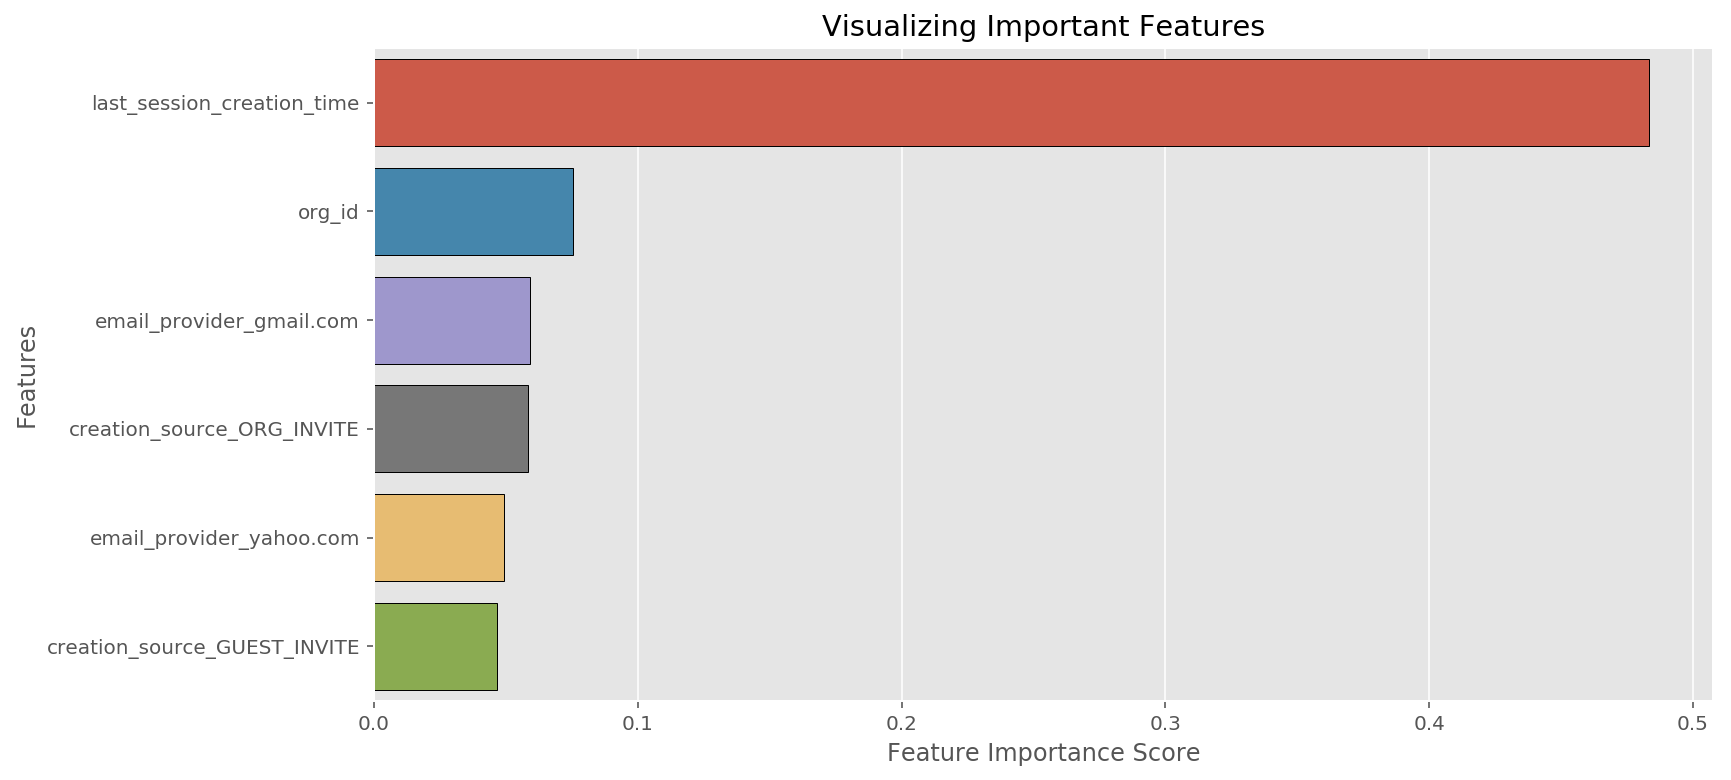

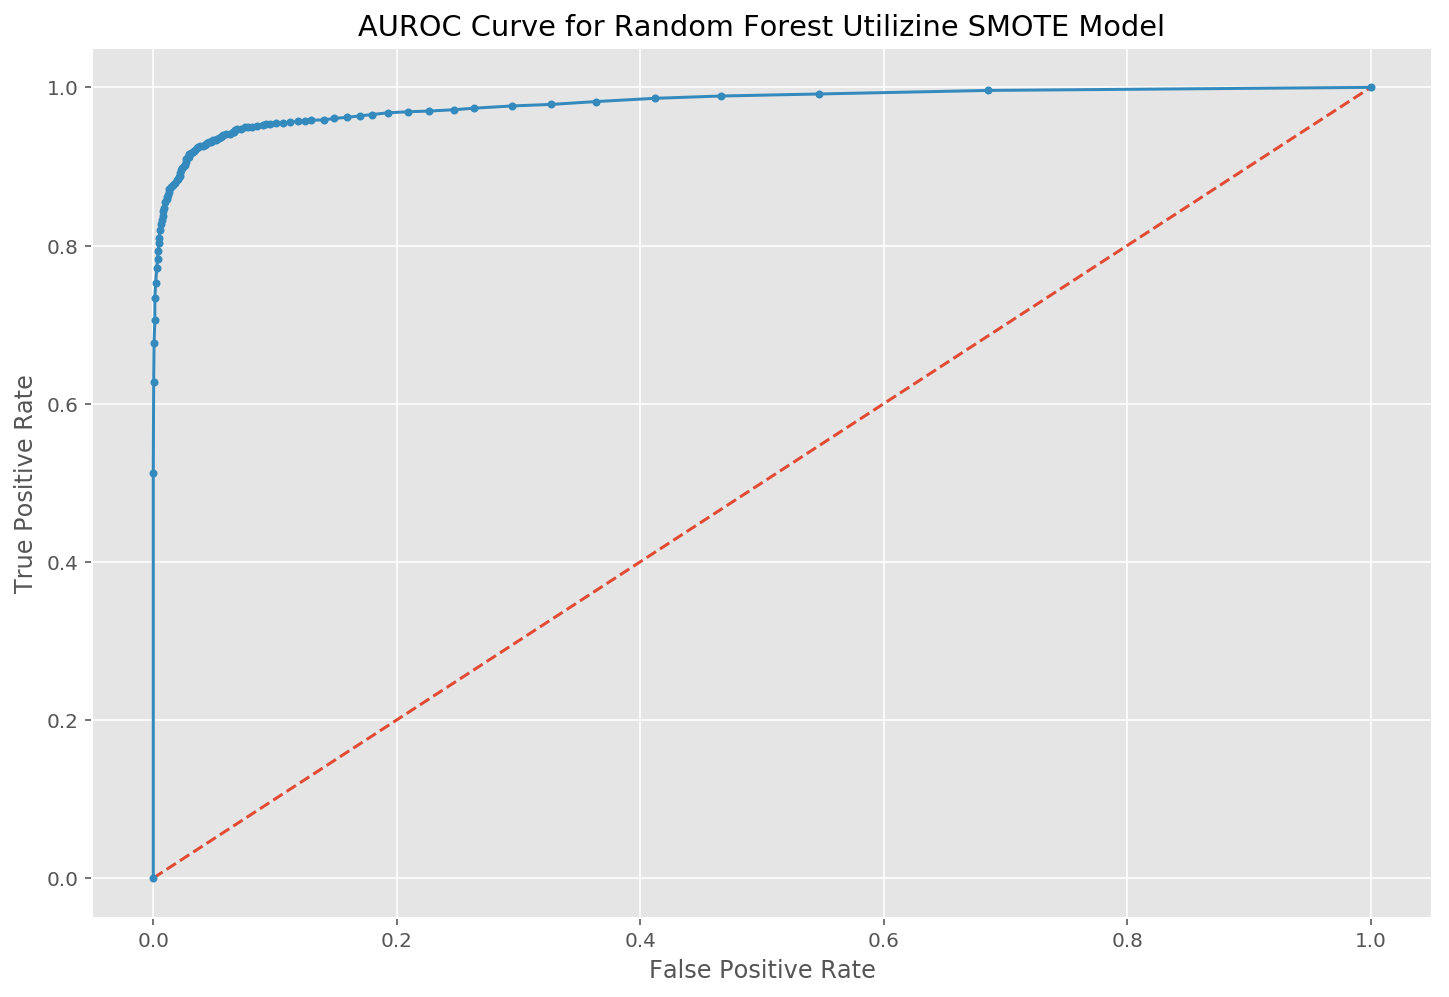

In [249]:
relax.ml_smote(X, y, random_state=1, title='Random Forest Utilizine SMOTE');

# _Observations_

As we can see above, SMOTE helped significantly with the model's performance. `last_session_creation_time` still appears to be the most significant feature, but there are others - such as `org_id`, email provider and creation source - that were more important features than the baseline model. 